## Importing libraries

In [461]:
# Importing nessesary libraries
import unicodedata
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import Counter
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torch
import os
from math import log
import tensorflow as tf
import nltk

In [2]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing data

In [4]:
# Download the text file from tensorflow
import pathlib

path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = pathlib.Path(path_to_zip).parent/'spa-eng/spa.txt'

2638744/2638744 [==============================] - 1s 0us/step


In [5]:
# Loading dataset
# Source: https://www.tensorflow.org/text/tutorials/nmt_with_attention
def load_data(path):
  text = path.read_text(encoding='utf-8')
  lines = text.splitlines()
  pairs = [line.split('\t') for line in lines]
  context = np.array([context for target, context in pairs])
  target = np.array([target for target, context in pairs])
  return target, context

In [6]:
numSamples = 30000

In [7]:
target_raw, context_raw = load_data(path_to_file)

After loading the dataset, we can take a look at some of the text data:

In [8]:
idx = -1
print(target_raw[idx])
print(context_raw[idx])

If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo.
Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un músico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado.


## Preprocessing I: Text normalization

As the first step of preprocessing, we transform all characters to lowercase and Unicode, while also eliminating punctuation at the end of each sentence.

In [9]:
# Takes in a setence (string) and normalize all characters to unicode

def normalize_unicode(text, normalization_form='NFC'):
    normalized_text = unicodedata.normalize(normalization_form, text)
    return normalized_text

In [10]:
# Takes in an array of sentences, for each sentence, perform the following operations
# lower case -> normalize unicode -> remove period at the end

def normalize(text_array):
    return_array = []
    for sentence in text_array:
        sentence = sentence.lower()
        sentence = normalize_unicode(sentence)
        sentence = sentence.replace('.', '')
        return_array.append(sentence)
    return np.array(return_array)

In [11]:
print(f"Length of context raw: {len(context_raw)}")
print(f"Length of target raw: {len(target_raw)}")

Length of context raw: 118964
Length of target raw: 118964


In [12]:
context = normalize(context_raw)
target = normalize(target_raw)

In [13]:
context

array(['ve', 'vete', 'vaya', ...,
       'una huella de carbono es la cantidad de contaminación de dióxido de carbono que producimos como producto de nuestras actividades algunas personas intentan reducir su huella de carbono porque están preocupados acerca del cambio climático',
       'como suele haber varias páginas web sobre cualquier tema, normalmente sólo le doy al botón de retroceso cuando entro en una página web que tiene anuncios en ventanas emergentes simplemente voy a la siguiente página encontrada por google y espero encontrar algo menos irritante',
       'si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un músico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado'],
      dtype='<U276')

In [15]:
print(f"Length of context preprocessed: {len(context)}")
print(f"Length of target preprocessed: {len(target)}")

Length of context preprocessed: 118964
Length of target preprocessed: 118964


## Preprocessing II: Vectorization

In the second step of proprocessing, we numericalize each word using the custom Vocab class. The vocab class takes in an array of sentences and for each word in the sentence, assigns an index. The freq parameter is used to control the size of vocabulary. The vocab class also contains methods that converts numericalized sentences to word sentences.

In [16]:
# Initialize special tokens

START_TOKEN = 0
PAD_TOKEN = 1
END_TOKEN = 2
UNK_TOKEN = 3

In [17]:
# Implementation of the vocab class

class Vocab:
    def __init__(self, text_array, freq=2):
        self.text_array = text_array
        self.ttov = {"<sos>": START_TOKEN, "<pad>": PAD_TOKEN,
                     "<eos>": END_TOKEN, "<unk>": UNK_TOKEN}
        self.vtot = dict((idx, token) for token, idx in self.ttov.items())
        self.length = 4
        self.counter = Counter()
        self.freq = freq
        self.build_vocab()

    def add(self, token):
        self.ttov[token] = self.length
        self.vtot[self.length] = token
        self.length += 1

    def build_vocab(self):
        for sentence in self.text_array:
            for token in sentence.split():
                self.counter.update([token])

        for token, counter in self.counter.items():
            if counter >= self.freq:
                self.add(token)

    def vecToText(self, vec):
        text = []
        for v in vec:
            if v in self.vtot:
                text.append(self.vtot[v])
            else:
                text.append("<unk>")
        return text

    def textToVec(self, text):
        vec = []
        for t in text:
            if t in self.ttov:
                vec.append(self.ttov[t])
            else:
                vec.append(UNK_TOKEN)
        return torch.tensor(vec)

In [18]:
# Fitting the vocabs on both the context and target sentences

context_vocab = Vocab(context)
target_vocab = Vocab(target)

In [19]:
print(f"Length of context dictionary: {context_vocab.length}")
print(f"Length of target dictionary: {target_vocab.length}")

Length of context dictionary: 18169
Length of target dictionary: 11401


## Dataset

After preprocessing the sentences, we implement a custom Dataset class

In [20]:
# Implementation of dataset class

class TextDataset(Dataset):
    def __init__(self, context_array, target_array, context_vocab, target_vocab):
        if len(context_array) != len(target_array):
            raise ValueError("Lengths of context and target must be equal.")
        self.context = context_array
        self.target = target_array
        self.context_vocab = context_vocab
        self.target_vocab = target_vocab
        self.length = len(context_array)
        self.context_max_length = self.getMaxLen(self.context)
        self.target_max_length = self.getMaxLen(self.target)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        context = self.context_vocab.textToVec(self.context[idx].split())
        target = self.target_vocab.textToVec(self.target[idx].split())
        return context, target

    def getMaxLen(self, text_array):
        return len(max(self.context, key=lambda x: len(x.split())).split())

In [21]:
# Testing whether the dataset class works properly

data = TextDataset(context, target, context_vocab, target_vocab)
data.__getitem__(333)

(tensor([142, 311]), tensor([ 40, 192]))

In [22]:
CONTEXT_MAX_LENGTH = data.context_max_length
TARGET_MAX_LENGTH = data.target_max_length
print(f"Maximum length of context: {CONTEXT_MAX_LENGTH}")
print(f"Maximum length of target: {TARGET_MAX_LENGTH}")

Maximum length of context: 49
Maximum length of target: 49


## Dataloader

In [23]:
# Helper function for the dataloader class
# The collate_fn function pads each sentence to the same length

def collate_fn(batch):
    context, target = [data[0] for data in batch], [data[1] for data in batch]
    target_in = [torch.cat([torch.tensor([START_TOKEN]), text]) for text in target]
    target_out = [torch.cat([text, torch.tensor([END_TOKEN])]) for text in target]
    return pad(context, CONTEXT_MAX_LENGTH), pad(target_in, TARGET_MAX_LENGTH), pad(target_out, TARGET_MAX_LENGTH)

def pad(texts, max_len):
    padded = []
    for text in texts:
        while len(text) < max_len:
            text = torch.cat([text, torch.tensor([PAD_TOKEN])])
        padded.append(text)
    return torch.stack(padded)

## Encoder model

In [284]:
# B: Batch size
# L: Max length
# E: Embedding size
# H: Hidden size

class Encoder(nn.Module):
    def __init__(self, embed_size, vocab_size, hidden_size, dropout_p=0.1):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=PAD_TOKEN)
        self.rnn = nn.GRU(embed_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, context, training=True):
        # Context: [B, L]
        x = self.embedding(context) # [B, L, E]
        x = self.dropout(x) if training else None
        x, h = self.rnn(x)  # x: [B, L, H], h: [2, B, H]
        return x, h # x: [B, L, H], h: [1, B, H]

## Attention layer

In [285]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.Q = nn.Linear(hidden_size, hidden_size, bias=False)
        self.K = nn.Linear(hidden_size, hidden_size, bias=False)
        self.V = nn.Linear(hidden_size, 1, bias=False)

    # Query: RNN decoder hidden state: [B, 1, H]
    # Key: Encoder output: [B, L, H]
    # Value: Encoder output: [B, L, H]
    def forward(self, query, key):
        x = self.V(torch.tanh(self.Q(query) + self.K(key))) #[B, L, 1]
        x = x.squeeze(2).unsqueeze(1) #[B, 1, L]
        weights = F.softmax(x, dim=-1)
        context = torch.bmm(weights, key) #[B, 1, H]
        return context, weights

## Decoder model

In [286]:
class Decoder(nn.Module):
    def __init__(self, embed_size, vocab_size, hidden_size, dropout_p=0.1):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=PAD_TOKEN)
        self.attention = Attention(hidden_size)
        self.rnn = nn.GRU(embed_size + hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_out, hidden_init, target_in, training=True):
        decoder_hidden = hidden_init #[1, B, H]
        decoder_outputs = []
        attentions = []

        for t in range(TARGET_MAX_LENGTH):
            decoder_in = target_in[:, t].unsqueeze(1) #[B, 1]
            output, decoder_hidden, weights = self.forward_step(encoder_out, decoder_hidden, decoder_in, training)
            decoder_outputs.append(output)
            attentions.append(weights)

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        attentions = torch.cat(attentions, dim=1)
        logits = F.log_softmax(decoder_outputs, dim=-1)
        return logits, decoder_hidden, attentions

    def forward_step(self, encoder_out, decoder_hidden, decoder_in, training):
        token_embedded = self.embedding(decoder_in) #[B, 1, E]
        token_embedded = self.dropout(token_embedded) if training else None
        context, weights = self.attention(query=decoder_hidden.permute(1, 0, 2), key=encoder_out) #[B, 1, L], [B, 1, H]
        gru_input = torch.cat((token_embedded, context), dim=2) #[B, 1, E+H]
        output, decoder_hidden = self.rnn(gru_input, decoder_hidden) #[B, 1, H], [B, 1, H]
        output = self.out(output) #[B, 1, H]
        return output, decoder_hidden, weights #[B, 1, V], [1, B, H]

## Training preparations

Before training, the dataloaders and parameters are initialized

In [330]:
# Preprocess I: Normalize the sentences

numSamples = 50000
target_raw, context_raw = load_data(path_to_file)
target_raw, context_raw = target_raw[:numSamples], context_raw[:numSamples]
context = normalize(context_raw)
target = normalize(target_raw)
print(f"Length of preprocessed context: {len(context)}")
print(f"Length of preprocessed target: {len(target)}")

Length of preprocessed context: 50000
Length of preprocessed target: 50000


In [331]:
# Preprocess II: Numericalize the sentences

context_vocab = Vocab(context)
target_vocab = Vocab(target)
print(f"Length of context dictionary: {context_vocab.length}")
print(f"Length of target dictionary: {target_vocab.length}")

Length of context dictionary: 8623
Length of target dictionary: 5588


In [332]:
# Instantiating the dataset class

dataset = TextDataset(context, target, context_vocab, target_vocab)
CONTEXT_MAX_LENGTH = dataset.context_max_length
TARGET_MAX_LENGTH = dataset.target_max_length
print(f"Maximum length of context: {CONTEXT_MAX_LENGTH}")
print(f"Maximum length of target: {TARGET_MAX_LENGTH}")

Maximum length of context: 12
Maximum length of target: 12


In [333]:
# Performing train-test split

print(f"Size of dataset: {len(dataset)}")
train_ratio, val_ratio = 0.6, 0.2
train_size, val_size = int(len(dataset) * train_ratio), int(len(dataset) * val_ratio)
test_size = len(dataset) - train_size - val_size
print(f"Size of training data: {train_size}, validation data: {val_size}, test_data: {test_size}")

Size of dataset: 50000
Size of training data: 30000, validation data: 10000, test_data: 10000


In [334]:
# Instantiating training, validation, and testing dataloaders

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

In [335]:
# Model parameters

input_vocab_size = context_vocab.length
output_vocab_size = target_vocab.length
embed_size = 128
hidden_size = 128

## Training loop

In [336]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [337]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):

    total_loss = 0
    for context, target_in, target_out in dataloader:
        context = context.to(device)
        target_in = target_in.to(device)
        target_out = target_out.to(device)

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(context)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_in)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_out.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()
    return total_loss / len(dataloader)

In [338]:
def val_epoch(dataloader, encoder, decoder, criterion):
    total_loss = 0
    for context, target_in, target_out in dataloader:
        context = context.to(device)
        target_in = target_in.to(device)
        target_out = target_out.to(device)
        encoder_outputs, encoder_hidden = encoder(context)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_in)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_out.view(-1)
        )
        total_loss += loss.item()
    return total_loss / len(dataloader)

In [339]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001, print_every=100):
    train_history = []
    val_history = []

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        train_history.append(loss)

        if epoch % print_every == 0:
            val_loss = val_epoch(val_dataloader, encoder, decoder, criterion)
            val_history.append(val_loss)
            print(f"Epoch {epoch} with training loss {loss} and validation loss {val_loss} -----------------------------------------")

    return train_history, val_history

In [340]:
input_vocab_size = context_vocab.length
output_vocab_size = target_vocab.length

In [341]:
encoder = Encoder(embed_size, input_vocab_size, hidden_size).to(device)
decoder = Decoder(embed_size, output_vocab_size, hidden_size).to(device)

In [342]:
learning_rate = 0.001
optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

In [348]:
full_train_history, full_val_history = [], []

In [387]:
train_history, val_history = train(train_dataloader, encoder, decoder, n_epochs=20, learning_rate=0.001, print_every=1)

Epoch 1 with training loss 0.23143978022944445 and validation loss 0.8868987647591123 -----------------------------------------
Epoch 2 with training loss 0.21424433916235275 and validation loss 0.887894706171789 -----------------------------------------
Epoch 3 with training loss 0.20241819716084486 and validation loss 0.8892059189498804 -----------------------------------------
Epoch 4 with training loss 0.19281669081782482 and validation loss 0.9004877110955062 -----------------------------------------
Epoch 5 with training loss 0.1852953567274852 and validation loss 0.8939905971478505 -----------------------------------------
Epoch 6 with training loss 0.1763937305698771 and validation loss 0.9015903575405194 -----------------------------------------
Epoch 7 with training loss 0.17000023088157812 and validation loss 0.9050573418094854 -----------------------------------------
Epoch 8 with training loss 0.16318056398808067 and validation loss 0.9155039346901475 ---------------------

In [388]:
full_train_history.extend(train_history)
full_val_history.extend(val_history)

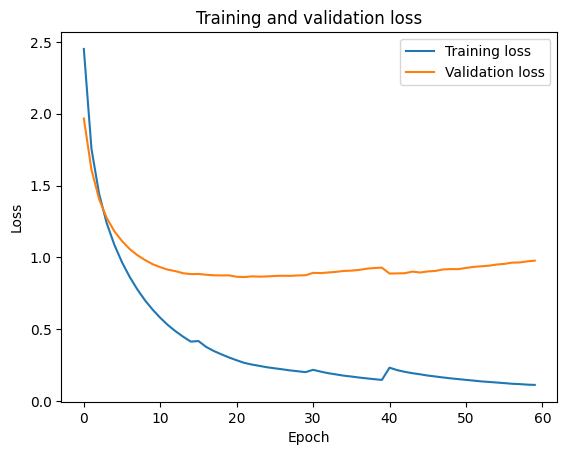

In [390]:
plt.plot(full_train_history, label="Training loss")
plt.plot(full_val_history, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

## Saving the Model

In [360]:
encoder_path = '/content/drive/MyDrive/Machine translation/50000_encoder128.pth'
torch.save(encoder.state_dict(), encoder_path)

In [361]:
decoder_path = '/content/drive/MyDrive/Machine translation/50000_decoder128.pth'
torch.save(decoder.state_dict(), decoder_path)

## Loading the Model

In [426]:
encoder_path = '/content/drive/MyDrive/Machine translation/50000_encoder128.pth'
encoder.load_state_dict(torch.load(encoder_path))

<All keys matched successfully>

In [427]:
decoder_path = '/content/drive/MyDrive/Machine translation/50000_decoder128.pth'
decoder.load_state_dict(torch.load(decoder_path))

<All keys matched successfully>

## Evaluation: greedy search

In [446]:
def evaluate(batch, encoder, decoder, context_vocab, target_vocab, search):
    context, target_in, target_out = batch
    context = context.to(device)
    target_in = target_in.to(device)
    target_out = target_out.to(device)

    encoder_outputs, encoder_hidden = encoder(context)

    encoder_outputs, encoder_hidden = encoder(context)
    decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_in)

    loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_out.view(-1))
    predicted_texts, true_texts = search(decoder_outputs, target_out, target_vocab)

    return predicted_texts, true_texts, loss.item()

In [447]:
def greedy_search(logits, target_out, target_vocab):
    batch_size = logits.shape[0]
    sentence_len = logits.shape[1]
    predicted_texts = []
    true_texts = []

    for batch in range(batch_size):
        predicted_text = []
        for t in range(sentence_len):
            predicted_text.append(torch.argmax(logits[batch][t]).item())
        predicted_text = target_vocab.vecToText(predicted_text)
        true_text = target_vocab.vecToText(target_out[batch, :].tolist())

        predicted_texts.append(predicted_text)
        true_texts.append(true_text)

    return predicted_texts, true_texts

In [448]:
def compare(predicted_texts, true_texts):
    for i in range(len(predicted_texts)):
        print(f"Sample {i + 1} ----------------------------------------------------------------")
        print(f"Predicted: {toSentence(predicted_texts[i])}")
        print(f"True: {toSentence(true_texts[i])}")
        print(f"-------------------------------------------------------------------------")
        print(f" ")

In [449]:
def toSentence(list_of_text):
    sentence = ""
    for t in range(len(list_of_text)):
        if list_of_text[t] == "<eos>" or list_of_text[t] == "<pad>":
            break
        sentence += list_of_text[t] + " "
    return sentence

In [450]:
test_dataloader = DataLoader(test_dataset, batch_size=15, shuffle=True, collate_fn=collate_fn)

In [451]:
test_batch = next(iter(test_dataloader))

In [452]:
predicted_texts, true_texts, test_loss = evaluate(test_batch, encoder, decoder, context_vocab, target_vocab, greedy_search)

In [453]:
print(f"The test loss is: {test_loss}")

The test loss is: 0.7648793458938599


In [454]:
compare(predicted_texts, true_texts)

Sample 1 ----------------------------------------------------------------
Predicted: they must be more polite 
True: you must be more polite 
-------------------------------------------------------------------------
 
Sample 2 ----------------------------------------------------------------
Predicted: the light is closed 
True: the lid is closed 
-------------------------------------------------------------------------
 
Sample 3 ----------------------------------------------------------------
Predicted: money has the world 
True: money rules the world 
-------------------------------------------------------------------------
 
Sample 4 ----------------------------------------------------------------
Predicted: were you worried? of that? 
True: were you aware of that? 
-------------------------------------------------------------------------
 
Sample 5 ----------------------------------------------------------------
Predicted: she hair cut hair 
True: her hair is dry 
-----------------

## Evaluation: Beam search

In [455]:
context, target_in, target_out = test_batch
context = context.to(device)
target_in = target_in.to(device)
target_out = target_out.to(device)

encoder_outputs, encoder_hidden = encoder(context)

encoder_outputs, encoder_hidden = encoder(context)
decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_in)

In [456]:
# Input logits: [L, V]
def beam_decode(logits, beam_width=3):
    sequences = [[list(), 0.0]]
    for row in logits:
        all_candidates = list()
        row = torch.softmax(torch.tensor(row), dim=-1).tolist()
        for i in range(len(sequences)):
            seq, score = sequences[i]
            for j in range(len(row)):
                candidate = [seq + [j], score - log(row[j])]
                all_candidates.append(candidate)
        ordered = sorted(all_candidates, key=lambda tup: tup[1])
        sequences = ordered[:beam_width]

    optimal_sequence = max(sequences, key=lambda tup: tup[1])[0]
    return optimal_sequence, sequences

In [457]:
def beam_search(logits, target_out, target_vocab, beam_width=5):
    batch_size = logits.shape[0]
    sentence_len = logits.shape[1]
    predicted_texts = []
    true_texts = []

    for batch in range(batch_size):
        opt_sequence, _ = beam_decode(logits[batch], beam_width=beam_width)
        predicted_text = target_vocab.vecToText(opt_sequence)
        true_text = target_vocab.vecToText(target_out[batch, :].tolist())

        predicted_texts.append(predicted_text)
        true_texts.append(true_text)

    return predicted_texts, true_texts

In [458]:
predicted_texts, true_texts, test_loss = evaluate(test_batch, encoder, decoder, context_vocab, target_vocab, beam_search)

<ipython-input-456-96f8f54ce8fd>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  row = torch.softmax(torch.tensor(row), dim=-1).tolist()


In [459]:
print(f"The test loss is: {test_loss}")

The test loss is: 0.8098700642585754


In [460]:
compare(predicted_texts, true_texts)

Sample 1 ----------------------------------------------------------------
Predicted: they must've be more polite 
True: you must be more polite 
-------------------------------------------------------------------------
 
Sample 2 ----------------------------------------------------------------
Predicted: the light is closed 
True: the lid is closed 
-------------------------------------------------------------------------
 
Sample 3 ----------------------------------------------------------------
Predicted: money is out same 
True: money rules the world 
-------------------------------------------------------------------------
 
Sample 4 ----------------------------------------------------------------
Predicted: were you talking to that? 
True: were you aware of that? 
-------------------------------------------------------------------------
 
Sample 5 ----------------------------------------------------------------
Predicted: she hair is dry 
True: her hair is dry 
-------------------